# Elo Loyalty Prediction

In [116]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.feature_selection import RFE

from sklearn.linear_model import LinearRegression

from xgboost.sklearn import XGBRegressor
from sklearn.inspection import partial_dependence, plot_partial_dependence

## Contents
- [Introduction](#introduction)
    * [Problem Statement](#problem-statement)
- [Exploratory Data Analysis](#eda)
- [Feature Engineering](#feature-engineering)
- [Model Building](#model-building)
    * [Linear Regression](#linear-regression)
    * [Gradient Bososted Tree](#gradient-boosted-trees)
        - [XGB Model Analysis](#xgb-model-analysis)
- [Conclusion](#conclusion)



## Introduction<a class="anchor" id="introduction"></a>


Elo, one of Brazil's largest payment brands, is partnered with many merchants to offer promotions and discounts to their cardholders. Elo aimed to reduce marketting that is irrelevant to members and offer them custom-tailored promotions, thereby providing an enjoyable experience and beneficial service. To that end, Elo launched a Kaggle competition, enlisting the Kaggle community's help, to produce a machine learning model that can find signal between trasaction data and loyalty. Such a model will help Elo gauge customer loyalty and how promotional strategies affect it.

**The data provided is simulated and fictitious. It does not contain real customer data.*


### Problem Statement<a class="anchor" id="problem-statement"></a>
Build a machine learning model that can effectively predict customer loyalty scores using trasaction data.

## Exploratory Data Analysis <a class="anchor" id="eda"></a>

The data contained five main tables consisting **train data**, **test data**, **historical transactions**, **new merchant transactions** and **merchants**.

**train data** table contained card_ids, loyalty scores and 3 arbitrary features provided by ELO. The aribtrary features were not very useful as they did not provide much signal in predicting loyalty scores.

**test data** table contained the same arbitrary features as **train data** and card_id but did not contain loyalty scores.

**historical transactions** contained details on purchases made by all the cardholders in the dataset. Details included purchase amount, merchant category, etc. Every card_id had atleaset 3 months of records.

**new merchant transactions** contained transaction data from new merchants the cardholder had not yet purchased from in the historical transaction data. Every card_id had upto two months of new merchant data after a reference date (which differed for each card_id).

**merchants** contained details on merchants seen in **historical transactions** and **new merchant transactions**


The data was heavily anonymized. Non-numerical data such as city of purchase and merchant category were reassigned with arbitrary value so it is difficult to connect real world knowledge and find insights.





In [4]:
# load data

# train data
traindf = pd.read_csv('./data/train.csv')

# given test data with no loyaltly score
giventestdf = pd.read_csv('./data/test.csv')
giventestdf['card_id'].nunique()

# historical transaction data
histtransdf = pd.read_csv('./data/historical_transactions.csv')

# new merchant transactional data
newtransdf = pd.read_csv('./data/new_merchant_transactions.csv')

# merchant data
merchdf = pd.read_csv('./data/merchants.csv')

In [5]:
# training dataset at glance
traindf.head()

,first_active_month,card_id,feature_1,feature_2,feature_3,target
0,2017-06,C_ID_92a2005557,5,2,1,-0.820283
1,2017-01,C_ID_3d0044924f,4,1,0,0.392913
2,2016-08,C_ID_d639edf6cd,2,2,0,0.688056
3,2017-09,C_ID_186d6a6901,4,3,0,0.142495
4,2017-11,C_ID_cdbd2c0db2,1,3,0,-0.159749


In [6]:
traindf.card_id.nunique()

201917

In [7]:
histtransdf.head()

,authorized_flag,card_id,city_id,category_1,installments,category_3,merchant_category_id,merchant_id,month_lag,purchase_amount,purchase_date,category_2,state_id,subsector_id
0,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-8,-0.703331,2017-06-25 15:33:07,1.0,16,37
1,Y,C_ID_4e6213e9bc,88,N,0,A,367,M_ID_86ec983688,-7,-0.733128,2017-07-15 12:10:45,1.0,16,16
2,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_979ed661fc,-6,-0.720386,2017-08-09 22:04:29,1.0,16,37
3,Y,C_ID_4e6213e9bc,88,N,0,A,560,M_ID_e6d5ae8ea6,-5,-0.735352,2017-09-02 10:06:26,1.0,16,34
4,Y,C_ID_4e6213e9bc,88,N,0,A,80,M_ID_e020e9b302,-11,-0.722865,2017-03-10 01:14:19,1.0,16,37


In [8]:
histtransdf['card_id'].nunique()

325540

In [9]:
histtransdf.shape

(29112361, 14)

In [10]:
newtransdf.card_id.nunique()

290001

In [11]:
merchdf['merchant_id'].nunique()

334633

There are 201,917 card ids in the training data set.

There are 123,623 card ids in the test data. This data cannot be used to train the model as it does not have loyalty scores (the response variable)

Hisotrical transaction data has 325,540 card ids with 29,112,361 transactions. Train and test card ids are both included in this historical data.

New merchant transactional data set had 290,001 card ids.

There were 334,633 different merchants in the merchant data.

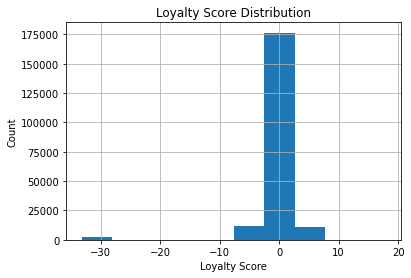

In [12]:
# plotting loyalty score distribution
traindf['target'].hist()
plt.xlabel('Loyalty Score')
plt.ylabel('Count')
plt.title('Loyalty Score Distribution');

Loyalty scores are normally distriubted ranging from -18 to 18. There are some outliers at -33.

## Feature Engineering<a class='anchor' id='feature-engineering'></a>

#### Features to Engineer <br>
*features are engineered to cardholder level* <br><br>
`tof` - (Time on File) Number of days between first and last purchase date of cardholder.<br><br>
`recency` - (Recency) Number of days between last date of all transactions and last date of purchase by a cardholder.<br><br>
`frequency` - (Frequency) Total number of transactions by a cardholder.<br><br>
`log_freq` - (Log(Frequency)) Log transformation of frequency may reduce outliers and linearize exponential trait of frequency distribution.<br><br>
`amt` - (Amount) Sum of all purchase amounts.<br><br>
`avg_amt` - (Average Amount) Average amount of all purchases.<br><br>
`charge_per_day` - (Charge per Day) Average number of transactions per day for cardholders time on file.<br><br>
`log_charge_per_day` - (Log(Charge per Day)) Log transform of charge per day. Linearizes exponential trait of charge_per_day.<br><br>
`max_amt` - (Max Purchase Amt) Highest purchase amount of a cardholder.<br><br>
`n_declines` - (Number of Declines) Number of times card was declined for a puchase. Authorized flag was 'N'.<br><br>
`log_n_declines` - (Log(Number of Declines)) Log transform of number of declines. Linearizes exponential trait of number of declines.<br><br>
`prop_new` - (Proportion New) Proportion of new merchant purchases in all purchases.<br><br>
`merch_cat_1_Y` - (Count when Merchant Category 1 is Yes) Sum of all times Anonymized merchant category 1 is yes.<br><br>
`merch_cat_2_x` - (Count when Merchant Category 2 is x) Sum of all times Anonymized merchant category 2 is x, where x can be values between 1-5.

In [13]:
# concatenating all transaction data and adding indicator of new merchant
histtransdf['new'] = False
newtransdf['new'] = True
alltransdf = pd.concat([histtransdf, newtransdf])

In [14]:
alltransdf['purchase_date'] = pd.to_datetime(alltransdf['purchase_date'])
alltransdf['authorized_flag'] = alltransdf.authorized_flag.apply(lambda x: True if x=='Y' else False)
alltransdf['city_id'] = alltransdf.city_id.apply(str)


In [15]:
last_day = alltransdf.purchase_date.max() # last day recorded in all of transactions
groups = alltransdf.groupby('card_id')

def safe_log(x):
    # log function to prevent getting log of zero
    if x <= 0:
        return 0
    else:
        return np.log(x)
    
# aggregating transactional data and features at card_id/cardholder level
cardholdersdf = pd.DataFrame()
cardholdersdf['tof'] = (last_day - groups.purchase_date.min()).apply(lambda x: x.days)
cardholdersdf['recency'] = (last_day - groups.purchase_date.max()).apply(lambda x: x.days)
cardholdersdf['frequency'] = groups.size()
cardholdersdf['log_freq'] = cardholdersdf.frequency.apply(np.log)
cardholdersdf['amt'] = groups.purchase_amount.sum()
cardholdersdf['avg_amt'] = cardholdersdf['amt'] / cardholdersdf['frequency']
cardholdersdf['charge_per_day'] = cardholdersdf['frequency'] / (cardholdersdf['tof'] + 1)
cardholdersdf['log_charge_per_day'] = cardholdersdf['charge_per_day'].apply(np.log)
cardholdersdf['max_amt'] = groups.purchase_amount.max()
cardholdersdf['n_declines'] = groups.size() - groups.authorized_flag.sum()
cardholdersdf['log_n_declines'] = cardholdersdf['n_declines'].apply(safe_log)
cardholdersdf['prop_new'] = groups.new.sum() / groups.size()
cardholdersdf['merch_cat_1_Y'] = groups.apply(lambda x: (x['category_1']=='Y').sum())
cardholdersdf['merch_cat_2_1'] = groups.apply(lambda x: (x['category_2']==1).sum())
cardholdersdf['merch_cat_2_2'] = groups.apply(lambda x: (x['category_2']==2).sum())
cardholdersdf['merch_cat_2_3'] = groups.apply(lambda x: (x['category_2']==3).sum())
cardholdersdf['merch_cat_2_4'] = groups.apply(lambda x: (x['category_2']==4).sum())
cardholdersdf['merch_cat_2_5'] = groups.apply(lambda x: (x['category_2']==5).sum())

In [16]:
new_train = traindf.join(cardholdersdf, how='left', on='card_id')
new_test = giventestdf.join(cardholdersdf, how='left', on='card_id')

In [17]:
# splitting predictor features from response
X_new_train = new_train.drop(columns=['first_active_month', 'target']).set_index('card_id')

# standardizing features
scaler = StandardScaler()
scaler.fit(X_new_train)
s_X_new_train = scaler.transform(X_new_train)
s_X_new_train = pd.DataFrame(data=s_X_new_train, columns=X_new_train.columns, index=X_new_train.index)

y_new_train = new_train['target']


In [18]:
# Additional EDA to see relationships between features and check for multicollinearity
#sns.pairplot(s_X_new_train)

## Model Building<a class='anchor' id='model-building'></a>

### Linear Regression <a class='anchor' id='linear-regression'></a>

In [50]:
# Cross Validation scheme
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

# RFE parameters
hyper_params = [{'n_features_to_select': list(range(1, 14))}]


# Linear Regression model to be put into rfe
lm = LinearRegression()
#lm.fit(s_X_new_train, y_new_train)

# RFE Recursive Feature Eliminations fits many times and prunes least important features every fit
rfe = RFE(lm)             
# Gridsearch tries to maximize scorer so negative rmse is used
scorers = {'R2':'r2', 'RMSE':'neg_root_mean_squared_error'}
# 3.2 call GridSearchCV()
model_cv = GridSearchCV(estimator = rfe, 
                        param_grid = hyper_params, 
                        scoring= ['r2','neg_root_mean_squared_error'],
                        refit='neg_root_mean_squared_error',
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(s_X_new_train, y_new_train) 

Fitting 5 folds for each of 13 candidates, totalling 65 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  65 out of  65 | elapsed:  1.2min finished


GridSearchCV(cv=KFold(n_splits=5, random_state=100, shuffle=True),
             estimator=RFE(estimator=LinearRegression()),
             param_grid=[{'n_features_to_select': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12, 13]}],
             refit='neg_root_mean_squared_error', return_train_score=True,
             scoring=['r2', 'neg_root_mean_squared_error'], verbose=1)

In [68]:
RFEdf = pd.DataFrame(zip(s_X_new_train.columns, model_cv.best_estimator_.ranking_),columns=['features','RFE_rank']).sort_values(by='RFE_rank')

In [67]:
selected_feats = s_X_new_train.columns[model_cv.best_estimator_.support_]

feat_imp = pd.DataFrame(zip(selected_feats,model_cv.best_estimator_.estimator_.coef_),columns=['feature','coefficient'])\
.sort_values(by='coefficient')

Text(0.5, 1.0, 'Features vs Coefficients')

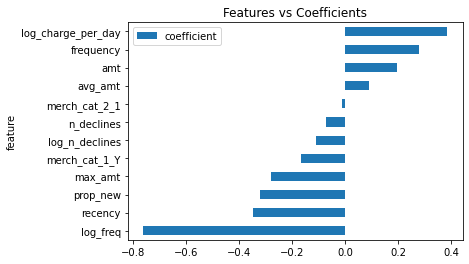

In [69]:
feat_imp.set_index('feature').plot.barh()
plt.title('Features vs Coefficients')

Since the data was standardized, the feature coefficients for linear regression can be compared directly. Log(Frequency) and Log(Charge per day) were the most influential features in determining loyalty score.

Text(0, 0.5, 'Test RMSE')

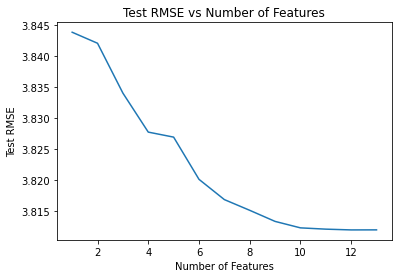

In [72]:
cv_results = pd.DataFrame(model_cv.cv_results_)
plt.plot(cv_results['param_n_features_to_select'],np.abs(cv_results['mean_test_neg_root_mean_squared_error']))
plt.title('Test RMSE vs Number of Features')
plt.xlabel('Number of Features')
plt.ylabel('Test RMSE')


In [77]:
abs(model_cv.best_score_)

3.811984889917428

In [84]:
cv_results['mean_test_r2'][11]

0.019182309970590738

The model with 12 Features had the lowest RMSE of about 3.812 and the R^2 value was 0.019. In comparison, the kaggle competition winner achieved an RMSE of 3.578 which is not too far off from this model. Although and R^2 of 0.019 is extremely low and suggests the model is barely getting any signal from the predictors.

### Gradient Boosted Trees <a class="anchor" id='gradient-boosted-trees'></a>

In [86]:
xgbreg = XGBRegressor(objective='reg:squarederror',
                      seed=42)

# randomized grid to get a starting point for model hyperparameters
random_grid = {'max_depth': range(2,10,1),
             'n_estimators':range(100,600,100),
             'learning_rate':[0.1, 0.3, 0.5],
             'min_child_weight':[0.1,0.5,1,2],
             'gamma':[0,0.1,1],
              'subsample':[0.1,0.5,1],
              'colsample_bytree':[0.1,0.5,1],
              'lambda':[0.1,0.5,1,2]} # lambda is l2 regularization on weights

# doing 3-fold cross-validation for 5 sets of hyperparameters chosen at random from above parameter grid
xgb_random = RandomizedSearchCV(estimator = xgbreg, 
                                param_distributions = random_grid,
                                n_iter = 5,
                                cv = 3,
                                random_state=42,
                                verbose = 10,
                                n_jobs=4,
                                scoring='neg_root_mean_squared_error')


xgb_random.fit(s_X_new_train, y_new_train)

xgbbest = xgb_random.best_estimator_

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   42.3s
[Parallel(n_jobs=4)]: Done  10 out of  15 | elapsed:  1.9min remaining:   57.0s
[Parallel(n_jobs=4)]: Done  12 out of  15 | elapsed:  2.3min remaining:   34.0s
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:  2.5min finished


In [87]:
xgb_random.best_params_

{'subsample': 1,
 'n_estimators': 100,
 'min_child_weight': 1,
 'max_depth': 3,
 'learning_rate': 0.1,
 'lambda': 2,
 'gamma': 0.1,
 'colsample_bytree': 1}

In [89]:
# Creating a parameter grid based on the results of random search 
# this steps further hones in the best parameters observed from the random search
param_grid = {
    'max_depth': [3,4],
    'n_estimators':[50,100,150],
    'learning_rate':[0.05,0.1],
    'min_child_weight':[1],
    'gamma':[0.1],
    'subsample':[1],
    'colsample_bytree':[1],
    'lambda':[2,3]}

# Create a base model
xgreg2 = XGBRegressor(objective='reg:squarederror',
                      seed=42)

# Instantiate the grid search model, 3 fold cross-validation on all 12 combinations from parameter grid
grid_search = GridSearchCV(estimator = xgbreg, 
                           param_grid = param_grid, 
                          cv = 3, n_jobs = 4, verbose = 10,
                          scoring=['neg_root_mean_squared_error','r2'], # scoring sets all performance metrics to be calculated
                          refit='neg_root_mean_squared_error') # refit sets metric to use when deciding best model

grid_search.fit(s_X_new_train, y_new_train)


Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   5 tasks      | elapsed:   25.9s
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:   44.3s
[Parallel(n_jobs=4)]: Done  17 tasks      | elapsed:  1.3min
[Parallel(n_jobs=4)]: Done  24 tasks      | elapsed:  1.8min
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  2.5min
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=4)]: Done  53 tasks      | elapsed:  4.0min
[Parallel(n_jobs=4)]: Done  64 tasks      | elapsed:  4.8min
[Parallel(n_jobs=4)]: Done  72 out of  72 | elapsed:  5.6min finished


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=4,
             param_grid={'colsample_bytree': [1], 'gamma': [0.1],
                         'lambda': [2, 3], 'learning_r

In [91]:
abs(grid_search.best_score_)

3.72821888656456

In [106]:
xgbcvres = pd.DataFrame(grid_search.cv_results_)
xgbcvres.sort_values(by='mean_test_neg_root_mean_squared_error',ascending=False).iloc[0,:]['mean_test_r2']

0.062477464846990904

The best Extreme Gradient Boosted model achieved a test CV RMSE of 3.728 and an R^2 of 0.062 which is considerable higher than the best linear regression model.

In [108]:
def plot_featimp(model_obj, feat_names, lim=None):
    ''' function to plot feature importance from tree models and returns feature important series'''
    if lim==None:
        lim=len(feat_names)
        
    feature_imp = pd.Series(model_obj.feature_importances_,index=feat_names)\
    .sort_values(ascending=False)[0:lim]
    
    plt.figure(figsize=(20,20))
    sns.barplot(x=feature_imp, y=feature_imp.index)
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.title('Visualizing Important Features')
    plt.show()
    
    return feature_imp

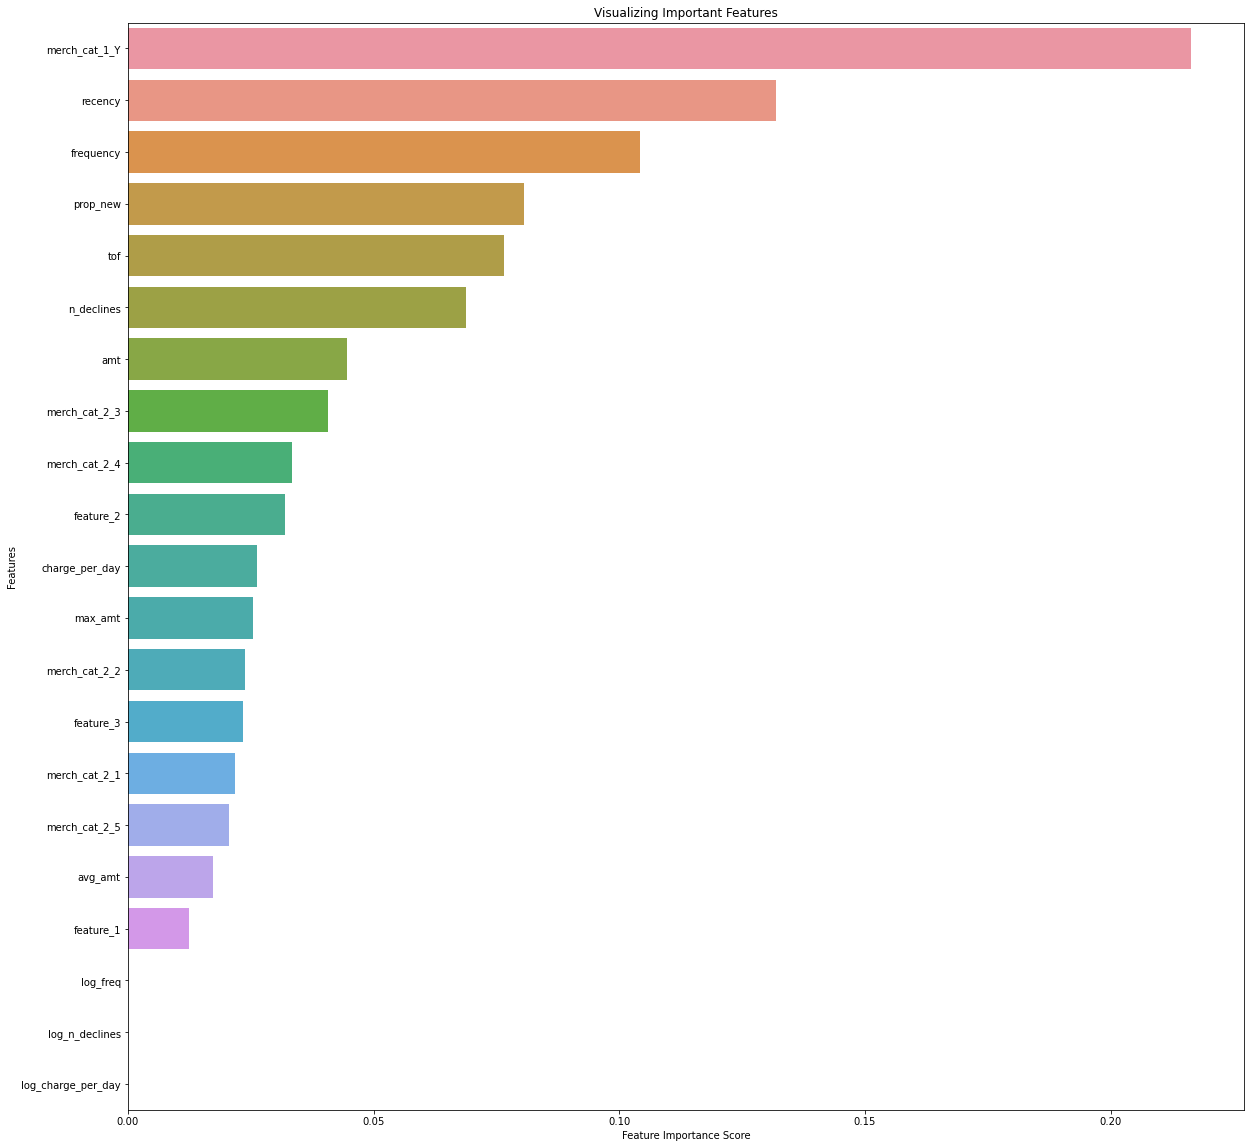

merch_cat_1_Y         0.216261
recency               0.131830
frequency             0.104117
prop_new              0.080680
tof                   0.076506
n_declines            0.068734
amt                   0.044516
merch_cat_2_3         0.040757
merch_cat_2_4         0.033483
feature_2             0.031963
charge_per_day        0.026269
max_amt               0.025407
merch_cat_2_2         0.023783
feature_3             0.023516
merch_cat_2_1         0.021882
merch_cat_2_5         0.020590
avg_amt               0.017249
feature_1             0.012457
log_freq              0.000000
log_n_declines        0.000000
log_charge_per_day    0.000000
dtype: float32

In [110]:
plot_featimp(grid_search.best_estimator_, s_X_new_train.columns)

The important feature chosen by the XGB model are slightly different than the linear regression. Merch_cat_1_Y was not as important for the linear regression but it turned out to be the most important for XGB. Recency, Frequency and Proportion of New Merchants are still considered important which is in agreement with linear regression.

### XGB Model Analysis <a class='anchor' id='xgb-model-analysis'></a>

#### Partial Dependence Plots

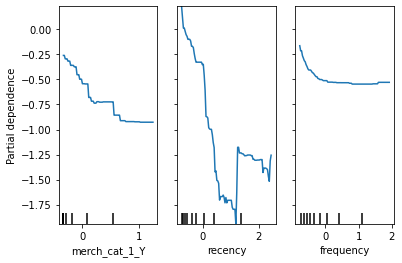

In [115]:
pdp_feats=['merch_cat_1_Y','recency','frequency']
# partial dependence plots can give insights as to how some features affect the model output
plot_partial_dependence(grid_search.best_estimator_, s_X_new_train, pdp_feats)

Partial Dependence Plots show the average effect of a predictor on the response. It can be seen the predictors barely impact response (Loyalty Score). The Loyalty score form the model ranges between 0 and -1 whereas the actual loyalty score ranges between -33 and 20. Marks on the x axis so data distribution.

In [147]:
pairplot_feats = ['merch_cat_1_Y','recency','frequency']
plotdf = s_X_new_train[pairplot_feats].copy()
plotdf['Loyalty Score'] = y_new_train.tolist()

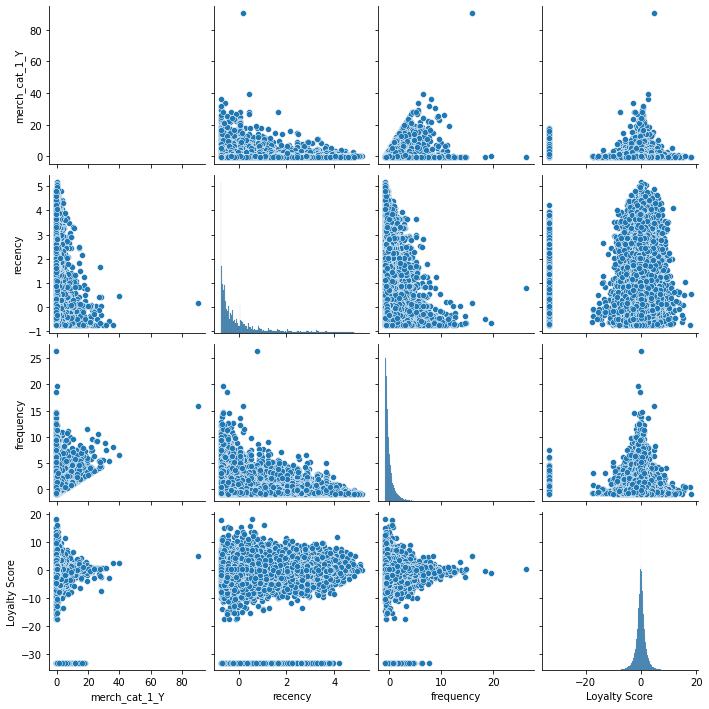

In [149]:
# scatter plot of actual values
sns.pairplot(plotdf)

Scatter plots could be used to discern relationships between predictors and response. No obvious pattern is observed.

## Conclusion <a class='anchor' id='conclusion'></a>

Upon testing linear regression and XGBoost model, the XGBoost model performed the best. XGBoost had a better RMSE and R^2 value, however neither model could effectively find signal between loyalty and the predictor features. The highest R^2 acheived in this investigation was about 0.06, suggesting simply using the average value for the loyalty score would provide performance comparable to the models.